In [2]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import analysis_utils
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. Please summarize the main characteristics of the dataset. Feel free to add visualizations as well



## Check List 
- data shape 
- data types
- missing values 
- Anomalies and outliers 
- unique values 
- values count, 
- Distrubutin: historgarm for numerical data, bar chart for categorical data
- Correlations 
- basic stats 


In [3]:
# download the csv file from here:
url = 'https://drive.google.com/uc?id=1U7TGQsqGOom_OqFXx7z925taVUEfd28O'

In [4]:
raw_data = pd.read_csv('data_assignment.csv')

/var/folders/f8/0lsxmrg55_b9lhrx3v76q9x80000gn/T/ipykernel_60165/1690271930.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_data = pd.read_csv('data_assignment.csv')


how many unique users we have? 

In [5]:
raw_data.user_id.shape[0], raw_data.user_id.unique().shape[0] 

(249232, 249232)

data shape:

In [6]:
raw_data.shape

(249232, 26)

In [7]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249232 entries, 0 to 249231
Data columns (total 26 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   time                  249232 non-null  object 
 1   user_id               249232 non-null  object 
 2   domain                249222 non-null  object 
 3   url                   249232 non-null  object 
 4   ad_slot               249232 non-null  object 
 5   country               249232 non-null  object 
 6   postal_code           201974 non-null  object 
 7   state_code            240773 non-null  object 
 8   city                  236697 non-null  object 
 9   user_agent            249194 non-null  object 
 10  cookie_age_seconds    249232 non-null  int64  
 11  detected_language     249033 non-null  object 
 12  device_type           249232 non-null  object 
 13  device_brand          111686 non-null  object 
 14  device_model          111687 non-null  object 
 15  

## data types

In [8]:
raw_data.dtypes.unique()

array([dtype('O'), dtype('int64'), dtype('float64')], dtype=object)

- we have int,float, objext and '0' 
- '0' means we have a format issue with some of the columns ,i.e columns with mixed types

In [9]:
cols_types = {col :pd.api.types.infer_dtype(raw_data[col]) for col in raw_data.columns}
cols_types

{'time': 'string',
 'user_id': 'string',
 'domain': 'string',
 'url': 'string',
 'ad_slot': 'string',
 'country': 'string',
 'postal_code': 'mixed',
 'state_code': 'string',
 'city': 'string',
 'user_agent': 'string',
 'cookie_age_seconds': 'integer',
 'detected_language': 'string',
 'device_type': 'string',
 'device_brand': 'string',
 'device_model': 'string',
 'screen_orientation': 'string',
 'publisher_properties': 'string',
 'is_wifi': 'integer',
 'viewability': 'integer',
 'session_depth': 'integer',
 'auction_type': 'string',
 'bidded': 'integer',
 'bid': 'floating',
 'won_bid': 'floating',
 'feedback_bid': 'floating',
 'conversion': 'floating'}

In [10]:

mixed_type_columns = [col for col, type in cols_types.items() if type == 'mixed']
mixed_type_columns

['postal_code']

we have 1 inconsistent column with mixed type.
postal_code

In [11]:
raw_data['datatype_postal_code'] = (
    raw_data['postal_code']
    .apply(
    lambda x: np.nan if pd.isna(x) else ('numeric' if type(x) == int or type(x) == float else 'str')
)
                                    )


how many "bad" rows do we have

In [12]:
raw_data[raw_data['datatype_postal_code']=='str'][['postal_code']].shape


(79523, 1)

if we want to fix this issue we need simply do the following:

In [13]:
(raw_data[raw_data['datatype_postal_code']=='str']['postal_code']
 .str.replace(r'[^\d]+', '', regex=True)
.astype(int)
 )

65536      42211
65537      85281
65539      54963
65540      90650
65541      77034
           ...  
163835    435370
163836    219210
163837     77530
163838    279680
163839    395810
Name: postal_code, Length: 79523, dtype: int64

we have ~ 80K rows that as bad format, they need to be converted to numeri.

## missing values 

### 'bid','won_bid','conversion', 'feedback_bid'

In [14]:
nans_cols = analysis_utils.percentage_nans(raw_data)
nans_cols

time                     0.000000
user_id                  0.000000
domain                   0.004012
url                      0.000000
ad_slot                  0.000000
country                  0.000000
postal_code             18.961450
state_code               3.394026
city                     5.029450
user_agent               0.015247
cookie_age_seconds       0.000000
detected_language        0.079845
device_type              0.000000
device_brand            55.187937
device_model            55.187536
screen_orientation       0.000000
publisher_properties     0.027284
is_wifi                  0.000000
viewability              0.000000
session_depth            0.000000
auction_type             0.000000
bidded                   0.000000
bid                     50.186172
won_bid                 50.186172
feedback_bid            50.186974
conversion              50.186172
datatype_postal_code    18.961450
dtype: float64

- we have some cols with missing values.
- some have very few 2 - 5 % and some have more than 50%. 
- lets start to examine the ones with high nans percentage. The nan may indicate another class and not a missing value.


lets again lool on only the cols with missing values: 

In [15]:
(pd.DataFrame(nans_cols)
 .rename(columns={0:'percentage_nans'})
.query('percentage_nans > 0')
 )

,percentage_nans
domain,0.004012
postal_code,18.961450
state_code,3.394026
city,5.029450
user_agent,0.015247
detected_language,0.079845
device_brand,55.187937
device_model,55.187536
publisher_properties,0.027284
bid,50.186172


In [16]:
raw_data['won_bid'].value_counts(normalize=True, dropna=False)

won_bid
NaN    0.501862
0.0    0.311316
1.0    0.186822
Name: proportion, dtype: float64

we have serval option for the nan values: 
1. it is missing data 
2. this are bids that the company did not took part it 
<br> so we need to look into it. Maybe other columns can help as indicators 

<br> bided is an indicator wether the company took part in the bid or not. 

lets see what are the values of the bid related columns when bidded == 0

In [17]:
# lets look on the other columns: 
not_bided = raw_data[raw_data['bidded']==0][['bid','won_bid','conversion', 'feedback_bid']]
not_bided

,bid,won_bid,conversion,feedback_bid
0,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN
...,...,...,...,...
249221,NaN,NaN,NaN,NaN
249222,NaN,NaN,NaN,NaN
249225,NaN,NaN,NaN,NaN
249228,NaN,NaN,NaN,NaN


as i suspected there are nans!

lets see if we can fix it? for the case wehre we have non and the company did not bid, we will replace the value -1 - indicating that the company did not bid. 

In [18]:
bid_related_columns_to_fill = ['bid', 'won_bid', 'conversion', 'feedback_bid']


raw_data_p1 =  (raw_data.pipe(
    analysis_utils
    .fill_na_based_on_condition,'bidded', bid_related_columns_to_fill )
    
    
    )


analysis_utils.percentage_nans(raw_data_p1)

time                     0.000000
user_id                  0.000000
domain                   0.004012
url                      0.000000
ad_slot                  0.000000
country                  0.000000
postal_code             18.961450
state_code               3.394026
city                     5.029450
user_agent               0.015247
cookie_age_seconds       0.000000
detected_language        0.079845
device_type              0.000000
device_brand            55.187937
device_model            55.187536
screen_orientation       0.000000
publisher_properties     0.027284
is_wifi                  0.000000
viewability              0.000000
session_depth            0.000000
auction_type             0.000000
bidded                   0.000000
bid                      0.000000
won_bid                  0.000000
feedback_bid             0.000802
conversion               0.000000
datatype_postal_code    18.961450
dtype: float64

We can see above that we manage to reduced the nan's rate sigidictnatly. there remain super low precentage of nans in the feedback bid, which are probably missing data. 

### postal_code

next lets deal with the postal code: 
<br> first lets deal with the mixed type issue. 

In [19]:
raw_data_fix_postal_code_type  = (
    raw_data
 .pipe(analysis_utils.fix_inconsistent_col_format,
        'postal_code',
          'datatype_postal_code',
            'numeric',
              'str'  )
 
 )

lets see if we fix the non consistant format issue: 


In [20]:
new_cols_types = analysis_utils.get_cols_type(raw_data_fix_postal_code_type)
new_cols_types['postal_code']

'integer'

Yes! i fixed the format issue. 
<br> now lets continue with the missing value issue. 

total rows = 249232
<br> how much unique postal code we have? ?

In [21]:
(
    raw_data_fix_postal_code_type
    .postal_code
    .unique()
    .shape[0]
)

19981

total special postal code = 19981 

lets try to add a col that will help us identify the missing values, or at least the most probable one.


In [22]:
raw_data_fix_postal_code_type= (
    raw_data_fix_postal_code_type
    .assign(country_state_city_code = lambda df: df['country']+'_'+df['state_code']+'_'+df['city'])
                                
                                )

how many sepcial country_state_city_code we have? 

In [23]:
raw_data_fix_postal_code_type.country_state_city_code.unique().shape[0]

11217

<br>ok so postal code we have 19981 unique values. 
<br> country_state_city_code we have 11217
<br>meaning there are few postal code per country_state_city_code. 
<br> we will do the follwing: we will create a dictionery: 
<br> country_state_city_code: mode(postal_code)


In [24]:
mode_dict_postal_code = (
    raw_data_fix_postal_code_type
    .groupby('country_state_city_code')
    ['postal_code']
    .agg(lambda x: pd.Series.mode(x)[0] if not pd.Series.mode(x).empty else None)
    .dropna()
    .to_dict()
 
 )

raw_data_fix_postal_code_type['postal_code'] =(
    raw_data_fix_postal_code_type.apply(
    lambda row: mode_dict_postal_code.get(row['country_state_city_code'], pd.NA) if pd.isna(row['postal_code']) else row['postal_code'],
    axis=1)
)

In [25]:
analysis_utils.percentage_nans(raw_data_fix_postal_code_type)['postal_code']

3.5388714129806766

with this method we manage to reduce the nans rate: 18 ->3.5, see results below 

In [26]:
analysis_utils.percentage_nans(raw_data_fix_postal_code_type)

time                        0.000000
user_id                     0.000000
domain                      0.004012
url                         0.000000
ad_slot                     0.000000
country                     0.000000
postal_code                 3.538871
state_code                  3.394026
city                        5.029450
user_agent                  0.015247
cookie_age_seconds          0.000000
detected_language           0.079845
device_type                 0.000000
device_brand               55.187937
device_model               55.187536
screen_orientation          0.000000
publisher_properties        0.027284
is_wifi                     0.000000
viewability                 0.000000
session_depth               0.000000
auction_type                0.000000
bidded                      0.000000
bid                         0.000000
won_bid                     0.000000
feedback_bid                0.000802
conversion                  0.000000
datatype_postal_code       18.961450
c

### device_model and device_brand

In [27]:
(
    raw_data
    [['device_type', 'device_brand', 'device_model', 'screen_orientation']]
 
 
 )

,device_type,device_brand,device_model,screen_orientation
0,PERSONAL_COMPUTER,NaN,NaN,UNKNOWN_ORIENTATION
1,PERSONAL_COMPUTER,NaN,NaN,UNKNOWN_ORIENTATION
2,HIGHEND_PHONE,motorola,xt1710-02,UNKNOWN_ORIENTATION
3,HIGHEND_PHONE,samsung,sm-s727v,UNKNOWN_ORIENTATION
4,PERSONAL_COMPUTER,NaN,NaN,UNKNOWN_ORIENTATION
...,...,...,...,...
249227,PERSONAL_COMPUTER,NaN,NaN,UNKNOWN_ORIENTATION
249228,PERSONAL_COMPUTER,NaN,NaN,UNKNOWN_ORIENTATION
249229,PERSONAL_COMPUTER,NaN,NaN,UNKNOWN_ORIENTATION
249230,HIGHEND_PHONE,apple,iphone,UNKNOWN_ORIENTATION


we can see that some of the nan in the 'device_brand' and in 'device_model' are due to the fact that the user used a personal computer 
lets add a category for this: generic_. We will fill the nan's for the 'device_brand' and in 'device_model' according to the 'device_type', add prefix 'generic_'

In [28]:
raw_data.device_type.unique()

array(['PERSONAL_COMPUTER', 'HIGHEND_PHONE', 'TABLET', 'GAME_CONSOLE'],
      dtype=object)

In [29]:
raw_data.device_model.unique()

array([nan, 'xt1710-02', 'sm-s727v', ..., 'sm-a505gn', 'x572', 'blade l5'],
      dtype=object)

In [30]:

raw_data.device_brand.unique()

array([nan, 'motorola', 'samsung', 'apple', 'alcatel', 'lg', 'google',
       'amazon', 'at&t', 't-mobile', 'oneplus', 'sonim', 'blu', 'android',
       'huawei', 'lenovo', 'onn', 'realme', 'nokia', 'xiaomi', 'umidigi',
       'zte', 'kyocera', 'unimax', 'hot pepper', 'coolpad', 'htc',
       'doogee', 'axia', 'cricket', 'microsoft', 'asus', 'rca', 'vankyo',
       'sky devices', 'wiko', 'ellipsis', 'ulefone', 'hp', 'foxxd',
       'nextbook', 'rokit', 'acer', 'hyundai', 'blackberry', 'vivo',
       'orbic', 'tecno', 'quanta', 'umx', 'barnes and noble', 'infinix',
       'dragon touch', 'sony', 'beista', 'trio', 'razer', 'nvidia', 'ans',
       'nuu', 'red', 'digiland', 'verizon', 'zopo', 'quantum',
       'blackview', 'essential', 'oppo', 'oukitel', 'dell', 'palm', 'cat',
       'leeco', 'sharp', 'tcl', 'azpen', 'winnovo', 'cubot', 'casper'],
      dtype=object)

In [31]:
raw_data_fix_nan_device = (raw_data
 .pipe(analysis_utils.fill_na_based_on_other_column, 'device_brand', 'device_type', 'generic_')
 .pipe(analysis_utils.fill_na_based_on_other_column, 'device_brand', 'device_type', 'generic_')
 )

analysis_utils.percentage_nans(raw_data_fix_nan_device)

time                     0.000000
user_id                  0.000000
domain                   0.004012
url                      0.000000
ad_slot                  0.000000
country                  0.000000
postal_code             18.961450
state_code               3.394026
city                     5.029450
user_agent               0.015247
cookie_age_seconds       0.000000
detected_language        0.079845
device_type              0.000000
device_brand             0.000000
device_model            55.187536
screen_orientation       0.000000
publisher_properties     0.027284
is_wifi                  0.000000
viewability              0.000000
session_depth            0.000000
auction_type             0.000000
bidded                   0.000000
bid                      0.000000
won_bid                  0.000000
feedback_bid             0.000802
conversion               0.000000
datatype_postal_code    18.961450
dtype: float64

it seems we manage to solve the main nan isseus, due to the short time i will not continue the anlysis with the remaing nans, since they are very small.

### summary the missing values part: 
Here is how to process the data to remove most of the NaNs. I did not apply the filling of -1 for the bid-related columns for convenience

In [32]:
raw_data = pd.read_csv('data_assignment.csv')
# Define columns that need NaN handling for bid-related data
bid_related_columns_to_fill = ['bid', 'won_bid', 'conversion', 'feedback_bid']

# Processing the DataFrame
raw_data = (
    raw_data
    # .pipe(
    #     analysis_utils.fill_na_based_on_condition,
    #     'bidded', 
    #     bid_related_columns_to_fill
    # )
    .assign(
        datatype_postal_code=lambda df: df['postal_code'].apply(
            lambda x: np.nan if pd.isna(x) else 
            ('numeric' if type(x) == int or type(x) == float else 'str')
        )
    )
    .pipe(
        analysis_utils.fix_inconsistent_col_format,
        'postal_code',
        'datatype_postal_code',
        'numeric',
        'str'
    )
    .assign(
        country_state_city_code=lambda df: 
        df['country'] + '_' + df['state_code'] + '_' + df['city']
    )
    .pipe(
        analysis_utils.fillna_with_group_mode_to_dict,
        'country_state_city_code', 
        'postal_code'
    )
    .pipe(analysis_utils.fill_na_based_on_other_column, 'device_brand', 'device_type', 'generic_')
    .pipe(analysis_utils.fill_na_based_on_other_column, 'device_model', 'device_type', 'generic_')
)


/var/folders/f8/0lsxmrg55_b9lhrx3v76q9x80000gn/T/ipykernel_60165/3037256812.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_data = pd.read_csv('data_assignment.csv')


In [33]:
analysis_utils.percentage_nans(raw_data)

time                        0.000000
user_id                     0.000000
domain                      0.004012
url                         0.000000
ad_slot                     0.000000
country                     0.000000
postal_code                 3.538871
state_code                  3.394026
city                        5.029450
user_agent                  0.015247
cookie_age_seconds          0.000000
detected_language           0.079845
device_type                 0.000000
device_brand                0.000000
device_model                0.000000
screen_orientation          0.000000
publisher_properties        0.027284
is_wifi                     0.000000
viewability                 0.000000
session_depth               0.000000
auction_type                0.000000
bidded                      0.000000
bid                        50.186172
won_bid                    50.186172
feedback_bid               50.186974
conversion                 50.186172
datatype_postal_code       18.961450
c

## Summary statistics

Also, I would want to analyze the numeric and object columns separately.


In [34]:
numeric_cols = raw_data.select_dtypes(include=['number']).columns
object_cols = raw_data.select_dtypes(include=['object']).columns
len(numeric_cols), len(object_cols)

(9, 19)

In [35]:
print("Summary statistics for numeric columns:")
display(raw_data[numeric_cols].describe())



Summary statistics for numeric columns:


,cookie_age_seconds,is_wifi,viewability,session_depth,bidded,bid,won_bid,feedback_bid,conversion
count,2.492320e+05,249232.000000,249232.000000,249232.000000,249232.000000,124152.000000,124152.000000,124150.000000,124152.000000
mean,8.914815e+06,0.926615,56.853787,11.164782,0.498138,4.133353,0.375040,4.837522,0.035183
std,1.439282e+07,0.260769,32.712160,40.078729,0.499998,20.868548,0.484135,26.679007,0.184242
min,0.000000e+00,0.000000,-1.000000,-1.000000,0.000000,0.060000,0.000000,0.010000,0.000000
25%,0.000000e+00,1.000000,32.000000,-1.000000,0.000000,0.301924,0.000000,0.500000,0.000000
50%,2.592000e+05,1.000000,67.000000,-1.000000,0.000000,0.740403,0.000000,1.410000,0.000000
75%,1.296000e+07,1.000000,84.000000,2.000000,1.000000,1.830171,1.000000,3.290000,0.000000
max,6.220800e+07,1.000000,100.000000,303.000000,1.000000,700.000000,1.000000,1243.750000,1.000000


lets see if anytning change if the bidded =1 

In [36]:
raw_data[numeric_cols].query('bidded == 1').describe()

,cookie_age_seconds,is_wifi,viewability,session_depth,bidded,bid,won_bid,feedback_bid,conversion
count,1.241520e+05,124152.000000,124152.000000,124152.000000,124152.0,124152.000000,124152.000000,124150.000000,124152.000000
mean,8.928913e+06,0.913155,58.268067,7.788066,1.0,4.133353,0.375040,4.837522,0.035183
std,1.428138e+07,0.281609,32.048034,31.030120,0.0,20.868548,0.484135,26.679007,0.184242
min,0.000000e+00,0.000000,-1.000000,-1.000000,1.0,0.060000,0.000000,0.010000,0.000000
25%,0.000000e+00,1.000000,36.000000,-1.000000,1.0,0.301924,0.000000,0.500000,0.000000
50%,3.456000e+05,1.000000,68.000000,-1.000000,1.0,0.740403,0.000000,1.410000,0.000000
75%,1.296000e+07,1.000000,84.000000,1.000000,1.0,1.830171,1.000000,3.290000,0.000000
max,6.220800e+07,1.000000,100.000000,300.000000,1.0,700.000000,1.000000,1243.750000,1.000000


In [37]:
raw_data.query('bidded==1')['session_depth'].value_counts(normalize=True).head(5)

session_depth
-1    0.570325
 1    0.186167
 2    0.031486
 3    0.012509
 9    0.011711
Name: proportion, dtype: float64

In [38]:
raw_data.query('bidded==1')['session_depth'].value_counts(normalize=True).iloc[0], raw_data['session_depth'].value_counts(normalize=True).iloc[0]

(0.5703250853792126, 0.5806758361687103)

for sessino depth we see that most of the values equal -1 (the most probable value), i.e was not indetified. 
yet we need to look on biided =1 and won bids ! 

In [39]:
raw_data.query('bidded==1 and won_bid ==1')['session_depth'].value_counts(normalize=True).head(5)

session_depth
-1      0.621365
 1      0.185087
 2      0.024419
 300    0.011146
 3      0.009879
Name: proportion, dtype: float64

we can see that the values is still quite high 

lets look at the object columns: 
- how many unique values do we have in each column? 

In [40]:
{col : raw_data[col].unique().shape[0] for col in object_cols}

{'time': 248738,
 'user_id': 249232,
 'domain': 8636,
 'url': 44208,
 'ad_slot': 35255,
 'country': 1,
 'postal_code': 19981,
 'state_code': 52,
 'city': 7995,
 'user_agent': 20658,
 'detected_language': 41,
 'device_type': 4,
 'device_brand': 81,
 'device_model': 1237,
 'screen_orientation': 1,
 'publisher_properties': 6803,
 'auction_type': 2,
 'datatype_postal_code': 3,
 'country_state_city_code': 11217}

In [41]:
raw_data.time.max(),raw_data.time.min()

('2021-02-01 23:59:59.927888 UTC', '2021-02-01 00:00:00.122461 UTC')

- all the data is from the US
- only 1 screen orientation
- 41 languge 
- time: data from 1 day
- what is the dominent device type?, device model ? language? city 

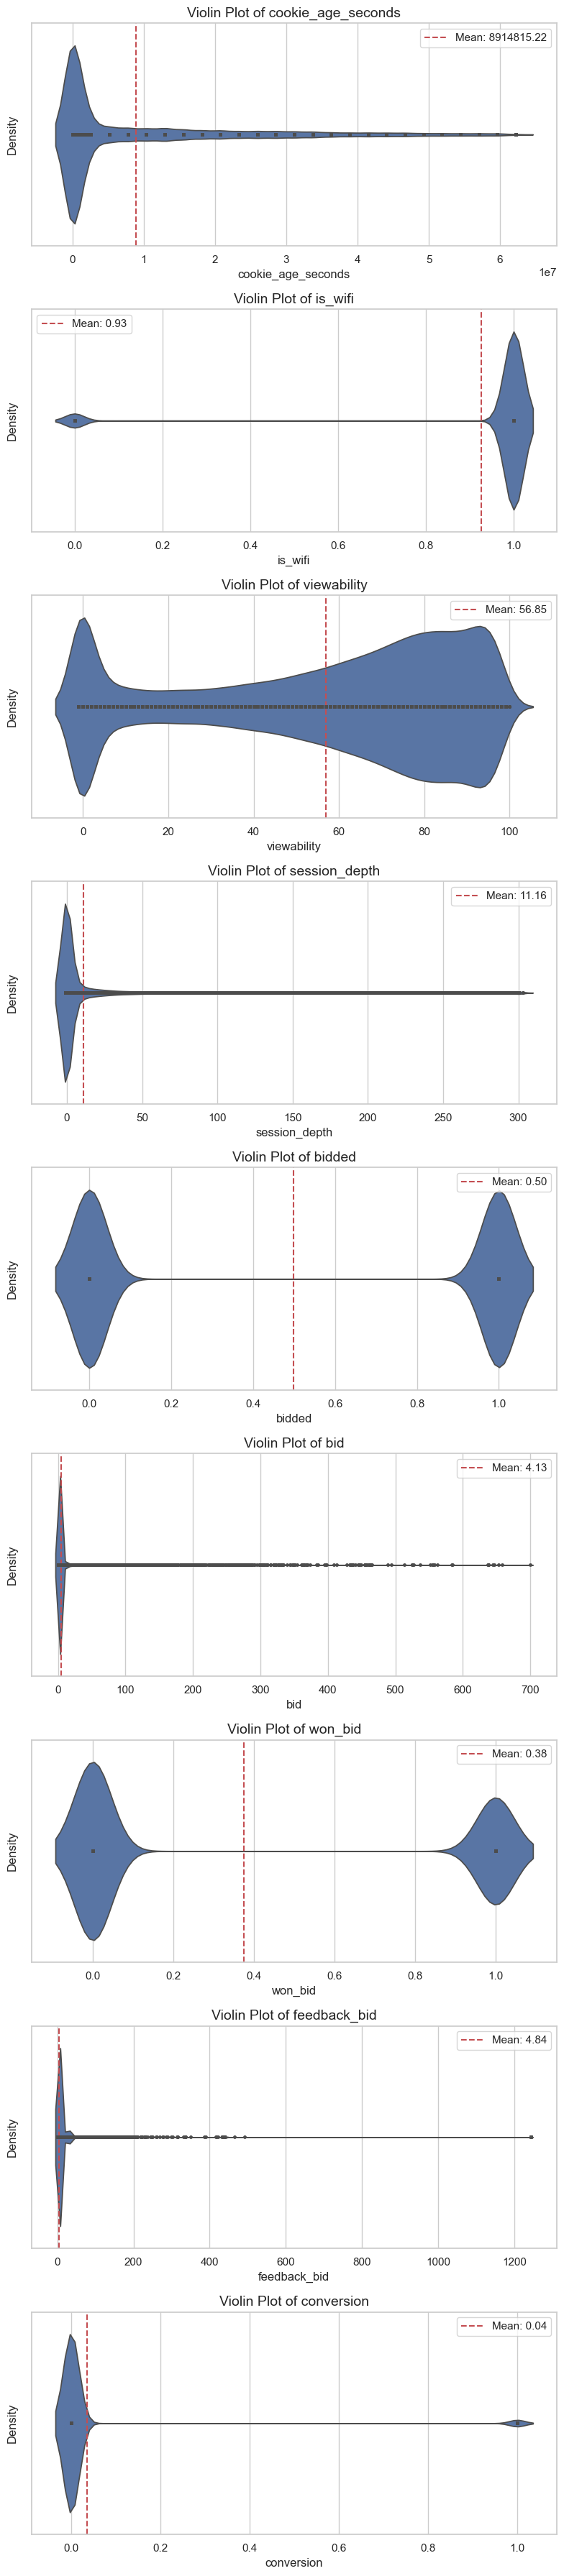

In [42]:
sns.set(style="whitegrid")

fig, axes = plt.subplots(nrows=len(numeric_cols), ncols=1, figsize=(8, 4 * len(numeric_cols)))

for ax, col in zip(axes.flat, numeric_cols):
    sns.violinplot(x=raw_data[col], ax=ax,  inner='point')

    ax.set_title(f'Violin Plot of {col}', fontsize=14)  # Set title for each plot
    ax.set_ylabel('Density')  # Label for y-axis
    ax.set_xlabel(col)  # Label for x-axis

    # Add a line for the mean
    mean_val = raw_data[col].mean()
    ax.axvline(mean_val, color='r', linestyle='--', linewidth=1.5, label=f'Mean: {mean_val:.2f}')
    ax.legend()

# Adjust layout
plt.tight_layout()
plt.show()

In [43]:
raw_data['bid']

0              NaN
1         1.649047
2         1.005495
3         5.852967
4              NaN
            ...   
249227    5.163571
249228         NaN
249229         NaN
249230    0.095408
249231    1.978379
Name: bid, Length: 249232, dtype: float64

## Outliers : 
- by viewing the violin plots, i can see that there are some outliers in the data with the follwoing columns: 
    -session depth 
    - bid 
    - feedback bid
yet regardng the session depth, this may be due to the fact that for high number of the data we dont know the session depth. 
- lets look on this colum without the -1: 


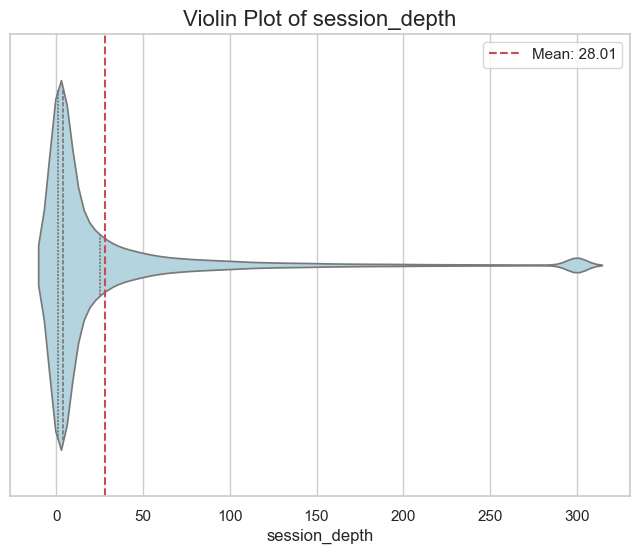

In [44]:
raw_data_ = raw_data.query('session_depth!= -1')
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
ax = sns.violinplot(x=raw_data_['session_depth'], color="lightblue", inner="quartile")  
ax.set_title('Violin Plot of session_depth', fontsize=16)  
ax.set_xlabel('session_depth', fontsize=12)
mean = raw_data_['session_depth'].mean()
plt.axvline(mean, color='r', linestyle='--', label=f'Mean: {mean:.2f}')
plt.legend()  
plt.show()

we still have outliers in the data. 

below we can look on the counts for the object columns we wanted to look at

In [45]:
print("\nFrequency counts for object columns:")
for col in ['city','auction_type', 'device_model', 'device_type', 'detected_language']:
    print(f"\nFrequency of {col}:")
    display(raw_data[col].value_counts(normalize=True))


Frequency counts for object columns:

Frequency of city:


city
Houston        0.010900
Atlanta        0.009197
Chicago        0.008669
Phoenix        0.007072
Los Angeles    0.006916
                 ...   
Vansant        0.000004
Gibbsboro      0.000004
Roberta        0.000004
Cross City     0.000004
Harwinton      0.000004
Name: proportion, Length: 7994, dtype: float64


Frequency of auction_type:


auction_type
FIRST_PRICE     0.911861
SECOND_PRICE    0.088139
Name: proportion, dtype: float64


Frequency of device_model:


device_model
generic_PERSONAL_COMPUTER    0.551474
iphone                       0.188627
ipad                         0.017097
sm-g960u                     0.010777
sm-g973u                     0.008129
                               ...   
z3001s                       0.000004
u673c                        0.000004
3622a                        0.000004
sm-a600fn                    0.000004
blade l5                     0.000004
Name: proportion, Length: 1237, dtype: float64


Frequency of device_type:


device_type
PERSONAL_COMPUTER    0.551474
HIGHEND_PHONE        0.419942
TABLET               0.028564
GAME_CONSOLE         0.000020
Name: proportion, dtype: float64


Frequency of detected_language:


detected_language
en       0.989178
es       0.006248
zh_CN    0.000787
ru       0.000771
ko       0.000377
ja       0.000333
id       0.000285
zh_TW    0.000277
pt       0.000229
de       0.000201
fr       0.000181
it       0.000100
te       0.000096
iw       0.000092
vi       0.000088
tr       0.000076
ar       0.000072
ml       0.000068
hr       0.000064
ta       0.000060
bn       0.000048
pl       0.000048
hi       0.000048
sr       0.000028
el       0.000028
mr       0.000024
tl       0.000024
no       0.000024
th       0.000020
nl       0.000020
da       0.000020
sv       0.000016
la       0.000016
ca       0.000012
ur       0.000008
gu       0.000008
bg       0.000008
sk       0.000004
ms       0.000004
fi       0.000004
Name: proportion, dtype: float64

In [46]:
(
    raw_data
    .query('bidded==1 and won_bid==1')
    .conversion
    .mean()

 
 
 )

0.09381040333319016

### Summary for part 1

We have a dataset comprising 9 numeric columns and 19 object columns. A preliminary examination of the numeric data suggests potential outliers or unusually high values, which could be attributed to errors or rare high bids. Interestingly, 92% of our data transmissions occur via WiFi. A significant observation from the session depth analysis reveals that for 62% of the entries for when we wom the bid, there's no data on the total number of impressions, 

Each row in our dataset represents a unique user. Initial review indicated a high number of NaNs, for which I've managed to account and suggest potential resolutions. A column with mixed types has been appropriately handled. On the conversion front, there is only a 9% conversion rate, for when we won the bid. Indicating that we are dealing with an imbalanced data issue. The dataset is entirely from the US, from a specific day,  with 6,803 unique publishers and 8,636 unique domains represented, and no single city dominates users wise. The predominant auction type observed is First Price, most users access via personal computers, and 98% of the users prefer English. 

# Let’s say we’re interested in predicting the click-through rate. What are the most promising features for this task at hand?

what is the relevant data to look at? 
i think is when we won the bid and that the user got an impression.

In [47]:
(raw_data
 .query('won_bid==1')
 .query('session_depth>1')
 .shape[0]
 
 
 )/raw_data.shape[0]

0.0361590806958978

we are left with 3 % of the data

now les look for features!

first candidate is time.

In [48]:
# filter data for the analysis
raw_data_filtered = (raw_data
 .query('won_bid==1')
 .query('session_depth>1')

)

lets see if the hour of the day can help us to predict.

In [49]:
raw_data_filtered['time'] = pd.to_datetime(raw_data_filtered['time'])

raw_data_filtered['hour'] = raw_data_filtered['time'].dt.hour


<Axes: xlabel='hour', ylabel='conversion'>

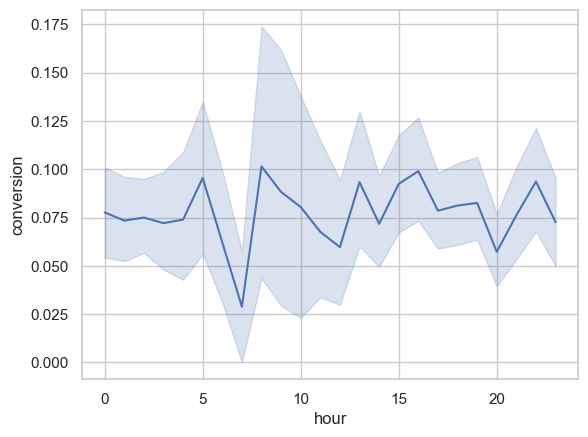

In [50]:

sns.lineplot(data=raw_data_filtered, x='hour', y='conversion', )


From the graph, it's evident that the conversion rate varies significantly throughout the day. Notably, there is a dip in conversion rates around noon, with peaks occurring in the morning and evening.

In [51]:
raw_data_filtered[numeric_cols].corr()['conversion']

cookie_age_seconds    0.011436
is_wifi              -0.071510
viewability           0.131860
session_depth        -0.121853
bidded                     NaN
bid                   0.066659
won_bid                    NaN
feedback_bid          0.090490
conversion            1.000000
Name: conversion, dtype: float64

yet the correlation is very small, yet the relation may be non- linear

In [52]:
total_num_users  =raw_data_filtered.user_id.nunique()
total_num_users

9012

Next feature - Domain: 

In [53]:
click_by_domain = (
    raw_data_filtered
    .groupby('domain')
    .agg(
    click_rate_by_domain = ('conversion','mean'),
    total_users = ('user_id', 'count')
    
    )
    
    
    )

click_by_domain


,click_rate_by_domain,total_users
domain,,
00822cfe9a3d3d4ebd3d3e7742937069,0.000000,4
00b966f16fcd7544ea8a8b7fc230b1b1,0.000000,1
00fba4432ddb68a7327498a478dbc0cf,0.166667,6
01dc0512b007f71baf5d868ec0e809ee,0.500000,2
0295eadadb165141f0bf7b45c63c7e5c,0.000000,1
...,...,...
fbed08751c52ea3c78ff9571301cbcd3,0.000000,1
fcd494925e576c493d173613afd0dcd0,0.000000,1
fd9b4fb778af7583470f8965ac412099,0.000000,1


how many users are using domains with conversion higher than 10%?

In [54]:
click_by_domain.query('click_rate_by_domain>0.1')[['total_users']].sum()/total_num_users

total_users    0.374945
dtype: float64

We observe that certain domains have a significant user base and a high conversion rate, with 37% of users accessing domains where the conversion exceeds 10%. Consequently, this could be a valuable feature for modeling. To incorporate this feature into a model, we will need to utilize a hashing encoder.

Next lets eximne device type:

In [55]:
raw_data_filtered[object_cols]['device_type'].unique()

array(['PERSONAL_COMPUTER', 'HIGHEND_PHONE', 'TABLET'], dtype=object)

In [56]:
(
    raw_data_filtered
    .groupby('device_type')
    .agg(
    click_rate_by_device_type = ('conversion','mean'),
    total_users = ('user_id', 'count')
    )
 
 )

,click_rate_by_device_type,total_users
device_type,,
HIGHEND_PHONE,0.141735,2547
PERSONAL_COMPUTER,0.052173,6306
TABLET,0.094340,159


The analysis indicates that users on high-end phones are significantly more likely to click on an ad than those using personal computers or tablets. Specifically, the likelihood of clicking an ad is five times greater for users with high-end phones compared to PC users. To confirm the statistical robustness of this finding, we also examined the total number of users for each device type. This consideration helps ensure that the feature is well-represented across the dataset, preventing any skewed conclusions that might result from a high conversion rate derived from a small sample size. Therefore, incorporating device type into the model, especially distinguishing between high-end phones and PCs, appears to be a promising predictor of ad click-through rates.

Next lets try some geographical features:
 - city 

In [57]:
raw_data_filtered.city.unique().shape

(2532,)

In [58]:
df_click_rate_by_city=(
    raw_data_filtered
    .groupby('city')
    .agg(
    click_rate_by_city = ('conversion','mean'),
    total_users = ('user_id', 'count')
    )
 
 )


In [59]:
df_click_rate_by_city.describe()

,click_rate_by_city,total_users
count,2531.000000,2531.000000
mean,0.090777,3.322797
std,0.244099,6.343503
min,0.000000,1.000000
25%,0.000000,1.000000
50%,0.000000,1.000000
75%,0.000000,3.000000
max,1.000000,89.000000


In [60]:
df_click_rate_by_city.query('total_users>10 and click_rate_by_city>0.01')

,click_rate_by_city,total_users
city,,
Albany,0.107143,28
Alexandria,0.071429,14
Anaheim,0.071429,14
Arlington,0.079365,63
Atlanta,0.069444,72
...,...,...
Tucson,0.062500,32
Warren,0.181818,11
Washington,0.088235,34


- The above analysis shows that while the median number of users per city is 1, the maximum reaches 89.
-  Given these statistics, a city having 10 users is significant enough to be noteworthy.
- Among the 2,500 cities analyzed, 95 cities exhibit a conversion rate higher than 10 percent and also have a sufficient number of users. This suggests that certain cities are reliable indicators of higher conversion rates.

Next lets look on viewability

In [61]:
# we can see that for most cases viewability can be estimated
raw_data_filtered.query('viewability==-1').shape

(298, 29)

In [62]:
raw_data_filtered.query('viewability>-1')[numeric_cols].corr()['conversion']

cookie_age_seconds    0.011158
is_wifi              -0.069275
viewability           0.128107
session_depth        -0.124167
bidded                     NaN
bid                   0.066720
won_bid                    NaN
feedback_bid          0.091853
conversion            1.000000
Name: conversion, dtype: float64

- we have low correlation between viewability and conversion rate
- lets try binning

In [63]:
raw_data_filtered_ = raw_data_filtered.query('viewability>-1')
labels = [0, 1, 2]  # low = 0, mid = 1, high = 2
bins = [0, 33, 66, 100]
raw_data_filtered_['viewability_bin'] = pd.cut(raw_data_filtered_['viewability'], bins=bins, labels=labels, include_lowest=True)

/var/folders/f8/0lsxmrg55_b9lhrx3v76q9x80000gn/T/ipykernel_60165/3174719509.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_data_filtered_['viewability_bin'] = pd.cut(raw_data_filtered_['viewability'], bins=bins, labels=labels, include_lowest=True)


In [64]:
raw_data_filtered_['viewability_bin'].astype(int).corr(raw_data_filtered_['conversion'])

0.1328911155717005

No improvement, lets try another feature

lets look on user agent, it is a known format, lets extrat data from it ! 


In [65]:
features_df = raw_data_filtered['user_agent'].apply(analysis_utils.extract_features).apply(pd.Series)

In [66]:

raw_data_filtered_ = pd.concat([raw_data_filtered, features_df[['browser_family','os_family']]], axis=1)

In [67]:
(
    raw_data_filtered_
    .groupby('browser_family')
    .agg(
    click_rate_by_browser_family = ('conversion','mean'),
    total_users = ('user_id', 'count')
    )
 .sort_values('click_rate_by_browser_family')
 .query('total_users>50 and click_rate_by_browser_family>0.1')
 )

,click_rate_by_browser_family,total_users
browser_family,,
Facebook,0.107364,1453
Samsung Internet,0.123529,170
Chrome Mobile WebView,0.182171,258
Chrome Mobile,0.226103,544


When evaluating the data for user engagement, it becomes clear that using Chrome as a browser significantly boosts conversion rates. For instance, users browsing with Chrome are twice as likely to click on an advertisement compared to those using Facebook's app/web.

 This observation indicates that Chrome is a reliable indicator for higher engagement and might be strategically advantageous for targeting in advertising campaigns.

lets do the same with OS:

In [68]:
(
    raw_data_filtered_
    .groupby('os_family')
    .agg(
    click_rate_by_os_family = ('conversion','mean'),
    total_users = ('user_id', 'count')
    )
 .sort_values('click_rate_by_os_family')
 )

,click_rate_by_os_family,total_users
os_family,,
Linux,0.000000,35
Other,0.000000,1
Mac OS X,0.035757,839
Chrome OS,0.054054,74
Windows,0.055058,5358
iOS,0.082019,317
Android,0.146566,2388


by the same argument we can say that os family is also a good indicator for the conversion rate.  Androind Users are 3 times more likely to click on an advertisement compared to those using Chrome OS.

In summary, my approach would include focusing on several key features:

- Domain: This could provide insights related to specific sites and their user engagement.
- City and additional geographical details: Such features could highlight regional trends or preferences.
- Time of day:  This factor is crucial for understanding peak user activities.
- Device type: Further investigation into this and other related attributes may yield valuable information about user behavior.
- Browser family and OS family: These could influence how users interact with ads.

Given additional time, I would also explore the URL and ad slot, especially considering the occurrence of repeated bids for these elements. It's plausible to believe that the URL and ad slot could significantly impact conversion rates. For example, ad slots in highly visible locations or on popular websites are likely to perform better.

# You’ve been asked to provide a way where we can guess (pre bid) the bid that will allow us to win X% of the time for every given url & ad slot . Given this dataset, how would you solve it?

- on what data should i look at?
the bided data. 

- for each url and ad_slot, can we have two different bids? first and second bid?
lets see:


In [69]:
data_on_bids_per_url_ad_slot = (
    raw_data_filtered
    .query('bidded ==1')
    .groupby(['url', 'ad_slot'])
    .agg(
        num_of_unique_auction_type = ('auction_type', 'nunique')
        ,
        num_of_unique_bid = ('bid', 'nunique')
        
    )
    
 
 )
data_on_bids_per_url_ad_slot.query('num_of_unique_auction_type>1')

num_of_unique_auction_type  \
url                              ad_slot                                                        
01b823ba4ad38adba6e2c1298661030a a05c0fe18824eaf96d954aeb8ad856d1                           2   
02edc7b9693f0c4651512a20f65d54fa a05c0fe18824eaf96d954aeb8ad856d1                           2   
                                 a6c4f795b6c97902cae215533c02afcd                           2   
0694486794c9faa7c7e5361a4b49a20e 3f5bc2958512394aec76cf08a60573b5                           2   
06b3751cea9440da3c09b5d008194780 f01d78fea16082e85c571282bebbc41d                           2   
...                                                                                       ...   
f433b3d65d643b805b6c07f7685a6d6e 2768a027d13eec4d128851b9a09a5016                           2   
f5eb5959d7311e7a1b3b3f48870cede9 2768a027d13eec4d128851b9a09a5016                           2   
f8682e384bd8054cf77aadddfd6456d6 297a745e12f2416f76d352d31eab1c4a                           2   
f960e45d4a59cb46ceb98b4888d7ab6c a6c4f795b6c97902cae215533c02afcd                           2   
f9d5a52dd4f94c9f38003b0d743c7553 feb283bf191f006e9aaefb146607adc5                           2   

                                                                   num_of_unique_bid  
url                              ad_slot                                              
01b823ba4ad38adba6e2c1298661030a a05c0fe18824eaf96d954aeb8ad856d1                  2  
02edc7b9693f0c4651512a20f65d54fa a05c0fe18824eaf96d954aeb8ad856d1                 12  
                                 a6c4f795b6c97902cae215533c02afcd                 14  
0694486794c9faa7c7e5361a4b49a20e 3f5bc2958512394aec76cf08a60573b5                  3  
06b3751cea9440da3c09b5d008194780 f01d78fea16082e85c571282bebbc41d                  2  
...                                                                              ...  
f433b3d65d643b805b6c07f7685a6d6e 2768a027d13eec4d128851b9a09a5016                  3  
f5eb5959d7311e7a1b3b3f48870cede9 2768a027d13eec4d128851b9a09a5016                  2  
f8682e384bd8054cf77aadddfd6456d6 297a745e12f2416f76d352d31eab1c4a                  8  
f960e45d4a59cb46ceb98b4888d7ab6c a6c4f795b6c97902cae215533c02afcd                  2  
f9d5a52dd4f94c9f38003b0d743c7553 feb283bf191f006e9aaefb146607adc5                  3  

[64 rows x 2 columns]

I observe that some ad slot+domain combinations receive bids in two distinct auction types. For simplicity, let's assume each has two auctions.

To estimate the bid necessary to win X% of the time, we'll begin by separating the bids for each URL and ad slot according to whether they're for first or second auctions. This separation is crucial because the bidding dynamics differ significantly between auction types. In first-price auctions, where the highest bid wins and pays what they bid, bidders tend to be more conservative to avoid overpaying.

Next, for a given URL and ad slot within a specific auction type, I would calculate the Xth quantile from the distribution of winning bids (not using the values we placed when we won, of course). This quantile should represent the bid amount that would win X% of the time, accounting for the unique bidding strategies typical of that auction type.

The limitation here is that accurately determining the quantile requires a substantial amount of data to adequately represent the distribution of winning bids.


for ease of use lets take one url-ad slot with high count of bids that we bidded.

In [70]:
data_on_bids_per_url_ad_slot.sort_values('num_of_unique_bid').iloc[[-1]]

,,num_of_unique_auction_type,num_of_unique_bid
url,ad_slot,,
2e14f82f96a3732eff1cf251d434bd3e,e593211fa5a63fa219c6f3e268daf009,1,58


Now lets get the 75 percentile of the winning bids for each url and ad_slot that we choose:

In [71]:
X = 75

(
    raw_data_filtered
    .query('bidded ==1')
    .query('url =="2e14f82f96a3732eff1cf251d434bd3e" and ad_slot ==  "e593211fa5a63fa219c6f3e268daf009"')
    [['feedback_bid']]
    .quantile(X / 100.0)
    
 
 )

feedback_bid    2.5
Name: 0.75, dtype: float64

we should put 2.5 CPM to win 75% of the time.

lets see if our method make sense?

In [72]:
(raw_data_filtered
    .query('bidded ==1')
    .query('url =="2e14f82f96a3732eff1cf251d434bd3e" and ad_slot ==  "e593211fa5a63fa219c6f3e268daf009"')
    .assign(precentile_wins = lambda df: df['feedback_bid']>2.5)
    ['precentile_wins'].mean()
    )

0.2465753424657534

we can see that only 24% of the the bids won values are higher the the value that we got for the 75 percentile, this is a good indicator for our method. 

the dowm side of this method is that we need to have enough data for each url and ad_slot to have a good estimation. 